# Visualsing the X-ray observations of LoVoCCS clusters

## Import Statements

In [25]:
from shutil import rmtree
import os
import pandas as pd
import numpy as np
from astropy.units import Quantity
from tqdm import tqdm

# I am only importing XGA because it has some quite handy product classes that we can use for some
#  of the visualisations
import xga
xga.NUM_CORES = 100
# This is a bodge that will only work because xga_output in notebooks has already been defined, XGA
#  will be made to handle this more gracefully at some point
temp_dir = xga.OUTPUT
actual_dir = temp_dir.split('notebooks/')[0]+'notebooks/xga_output/'
xga.OUTPUT = actual_dir
xga.utils.OUTPUT = actual_dir
if os.path.exists('xga_output'):
    rmtree('xga_output')
from xga.products import Image, ExpMap, RateMap

%matplotlib inline

## Reading in the sample

We need our sample information so that we can plot coordinates on images that we create, as well as possibly overlaying radius information:

In [4]:
samp = pd.read_csv("../../sample_files/lovoccs_southnorth.csv")
samp

,name,MCXC,LoVoCCSID,ra,dec,redshift,L500,M500,R500,alt_name,other_names,Notes
0,MCXCJ1558.3+2713,J1558.3+2713,0,239.585833,27.226944,0.0894,10.676087,8.1491,1.3803,RXCJ1558.3+2713,A2142,L
1,MCXCJ1510.9+0543,J1510.9+0543,1,227.729167,5.720000,0.0766,8.726709,7.2708,1.3344,A2029,A2029,NaN
2,MCXCJ0258.9+1334,J0258.9+1334,2,44.739583,13.579444,0.0739,6.088643,5.8488,1.2421,RXCJ0258.9+1334,A401,L
3,MCXCJ1348.8+2635,J1348.8+2635,3,207.220833,26.595556,0.0622,5.478067,5.5280,1.2236,RXCJ1348.8+2635,A1795,NaN
4,MCXCJ0041.8-0918,J0041.8-0918,4,10.458750,-9.301944,0.0555,5.100085,5.3163,1.2103,RXCJ0041.8-0918,A85,"L,losStr"
...,...,...,...,...,...,...,...,...,...,...,...,...
139,MCXCJ0448.2-2028,J0448.2-2028,139,72.050833,-20.469722,0.0720,1.004022,1.9513,0.8620,RXCJ0448.2-2028,A514,losStr
140,MCXCJ2323.8+1648,J2323.8+1648,140,350.972917,16.808889,0.0416,1.002026,1.9896,0.8760,A2589,A2589,NaN
141,MCXCJ1416.8-1158,J1416.8-1158,141,214.214583,-11.976111,0.0982,1.001648,1.9133,0.8491,RXCJ1416.8-1158,NaN,X
142,MCXCJ1459.0-0843,J1459.0-0843,142,224.764583,-8.725000,0.1043,1.001337,1.9047,0.8461,RXCJ1459.0-0843,NaN,NaN


## Defining useful paths

Paths useful to the entire notebook are added here, and we also make sure that the source-name-level output directories for the cluster visualisations have been created:

In [22]:
# This is where we store the output visualisations - where n is the name of the source, and {m} is the name
#  of the mission for which a visualisation is being made. The 'indiv' suffix is because these are individual 
#  ObsID-Instrument visualisations, not co-added
out_path = "../../outputs/cluster_visualisations/{n}/{m}_indiv/"

for lov_id in samp['LoVoCCSID'].values:
    lov_name = "LoVoCCS-{}".format(lov_id)
    
    if not os.path.exists('../../outputs/cluster_visualisations/{n}'.format(n=lov_name)):
        os.makedirs('../../outputs/cluster_visualisations/{n}'.format(n=lov_name))

## Making cluster visualisations

In this notebook we will limit ourselves to making visualisations of individual instruments of the different missions, rather than creating co-added images (even for instruments in the same mission, like the EPIC PN, MOS1, and MOS2 of XMM).

Here we will cycle through the available data, creating a visualisation for every valid observation-cluster combination (i.e. the cluster MCXC coordinate falls on the observation). Where they are immediately available we will use exposure maps to create visualisations with ratemaps, but where they are not we will (for now) just create photon-count images:

## XMM-Newton

As we processed raw XMM data with DAXA, we have to look to the DAXA archive directories to find the images and exposure maps required for this process. As exposure maps are available we will be creating visualisations of count-rate, rather than just counts. The visualisations will be in the 0.5-2.0keV band, where the majority of the cluster signal is present.

First of all we define some paths:

In [7]:
xmm_path = "../../data/archives/LoVoCCS/processed_data/xmm_pointed/"
xmm_im_path = xmm_path + "{oi}/images/{oi}_{i}_0.5-2.0keVimg.fits"
xmm_ex_path = xmm_path + "{oi}/images/{oi}_{i}_0.5-2.0keVexpmap.fits"


xmm_obs_ids = [fp for fp in os.listdir(xmm_path) if len(fp) == 10]

We cycle through all the observations that were successfully processed for XMM, and make ratemaps visualisations of all available EPIC instruments for each. Only one ratemap visualisation is displayed in the notebook, to ensure that it does not become too large:

  0%|          | 0/344 [00:00<?, ?it/s]

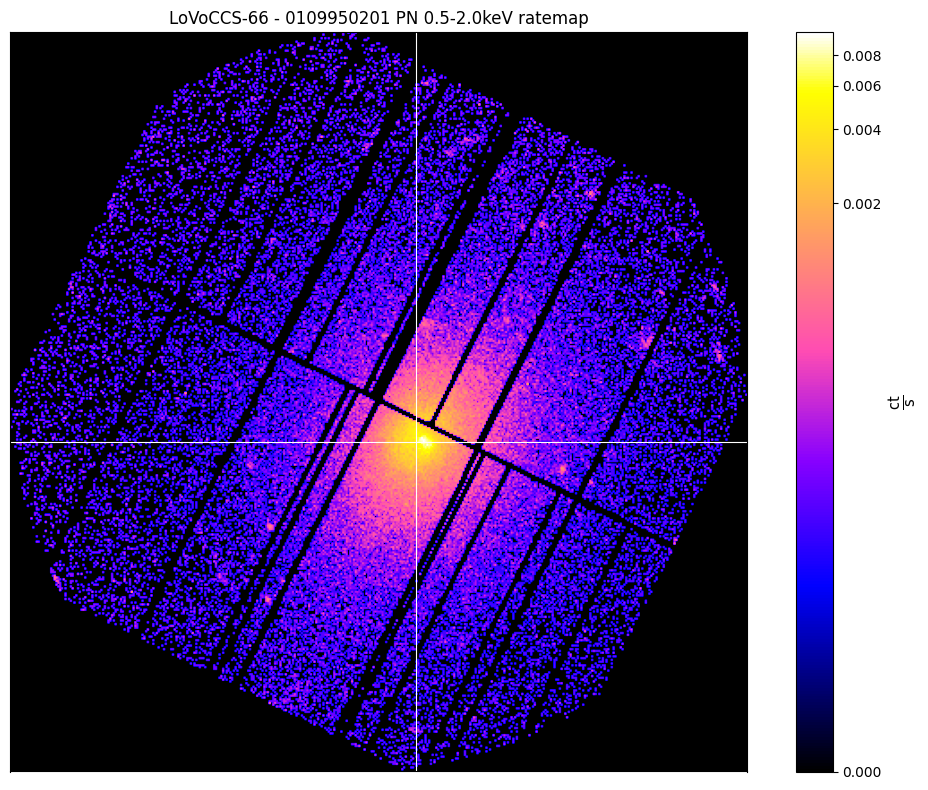

100%|██████████| 344/344 [09:35<00:00,  1.67s/it]


In [28]:
# This will flag will flip on the first successful image created - then images won't be shown in the notebook 
#  anymore, only saved to disk - this is to ensure that this notebook doesn't become so large that it causes 
#  problems loading it in, and rendering it on the GitHub website
show_vis = True

with tqdm('Generating XMM visualisations', total=len(xmm_obs_ids)) as onwards:
    for oi in xmm_obs_ids:
        for inst in ['pn', 'mos1', 'mos2']:
            cur_im = Image(xmm_im_path.format(oi=oi, i=inst), oi, inst, '', '', '', Quantity(0.5, 'keV'), 
                           Quantity(2.0, 'keV'))
            cur_ex = ExpMap(xmm_ex_path.format(oi=oi, i=inst), oi, inst, '', '', '', Quantity(0.5, 'keV'), 
                           Quantity(2.0, 'keV'))
            # If an image is not usable it is probably because that instrument doesn't have an image, and this is 
            #  just a brute force way of determing that rather than checking before I define
            if cur_im.usable:
                cur_rt = RateMap(cur_im, cur_ex)

                # Again this is unfortunately brute force, as I haven't yet added a feature that makes DAXA store
                #  which observation was for which input position/object. Once I have this will be removed
                for row_ind, row in samp.iterrows():
                    cur_name = "LoVoCCS-{}".format(row['LoVoCCSID']) 
                    cur_rt.src_name = cur_name
                    
                    cur_coord = Quantity(row[['ra', 'dec']], 'deg')
                    cur_out_path = out_path.format(n=cur_name, m='xmm')

                    try:
                        # We try this first because it will throw a ValueError that we can catch if the coordinate
                        #  is completely outside the valid region for this observation, without leaving an ugly
                        #  empty axis as would happen with the view method in that situation
                        cur_rt.coord_conv(cur_coord, 'pix')
                        if show_vis:
                            cur_rt.view(cur_coord, zoom_in=True)
                            # Now no-more visualisations will be shown in the notebook, only saved to disk
                            show_vis = False

                        # Make sure the output directory where we'll send the visualisation we're about to store
                        #  actually exists
                        if not os.path.exists(cur_out_path):
                            os.makedirs(cur_out_path)

                        # Then create a visualisation without displaying it, just saving it to disk
                        cur_rt.save_view(cur_out_path + '{n}_{o}_{i}.png'.format(n=cur_name, o=oi, i=inst), 
                                         cur_coord, zoom_in=True)

                    # If this is triggered it's because the current object isn't anywhere near this particular
                    #  observation - we don't have to worry though, it's just a consequence of the brute force
                    #  way that I'm currently doing this
                    except ValueError:
                        pass
        onwards.update(1)

## Chandra

Now we're on to missions that we have not processed data for ourselves; however we did tell DAXA to acquire the standard distribution of Chandra data, which includes full field-of-view FITS images, which we can use here. The standard data do not include pre-generated exposure maps, so we will be creating photon-count images, rather than count rate maps. The energy range also differs from XMM, as the standard images are made in the 0.5-7.0keV range.

Useful paths are defined, though we are not as specific about the structure of the image file name as we were with XMM, as the file name can change depending on the processing version and the instrument:

In [33]:
ch_path = "../../data/chandra_raw/"
ch_dat_path = ch_path + "{oi}/primary/"
ch_im_path = ch_path + "{oi}/primary/{im_f}"

ch_obs_ids = [fp for fp in os.listdir(ch_path)]

We cycle through all the observations that we acquired for Chandra, and make photon-count image visualisations for each. Only one image visualisation is displayed in the notebook, to ensure that it does not become too large:

  0%|          | 0/575 [00:00<?, ?it/s]

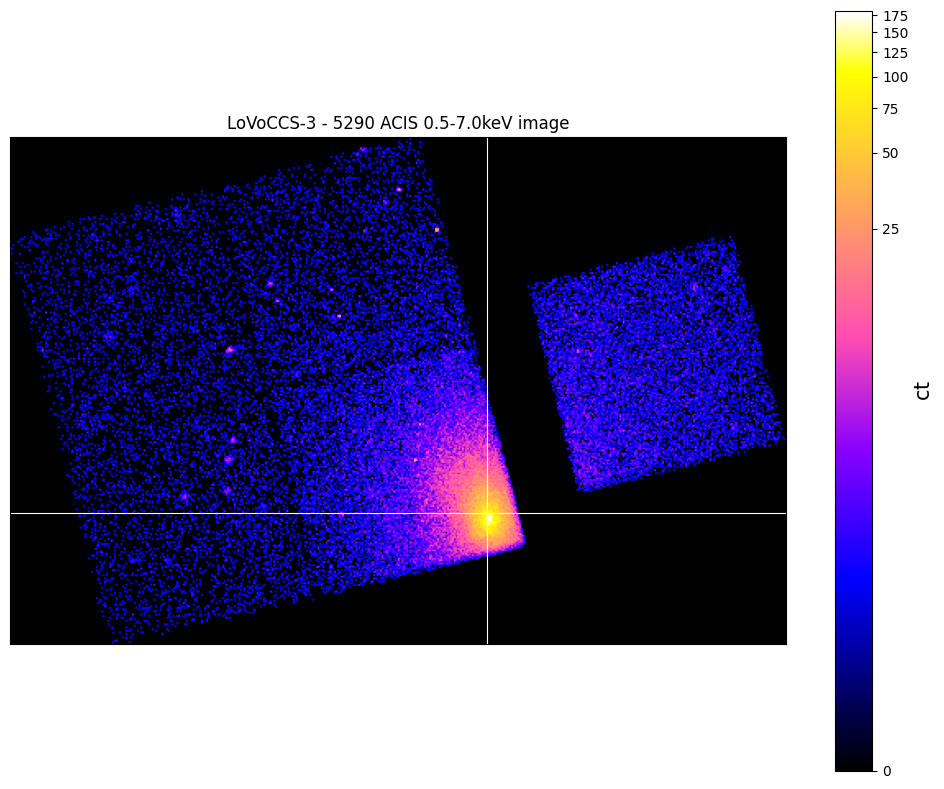

100%|██████████| 575/575 [04:44<00:00,  2.02it/s]


In [39]:
# This will flag will flip on the first successful image created - then images won't be shown in the notebook 
#  anymore, only saved to disk - this is to ensure that this notebook doesn't become so large that it causes 
#  problems loading it in, and rendering it on the GitHub website
show_vis = True

with tqdm('Generating Chandra visualisations', total=len(ch_obs_ids)) as onwards:
    for oi in ch_obs_ids:
        cur_im_path = ch_im_path.format(oi=oi, im_f=[f for f in os.listdir(ch_dat_path.format(oi=oi)) 
                                                     if 'full_img2' in f][0])
        inst = 'ACIS' if 'acis' in cur_im_path else 'HRC'
        
        cur_im = Image(cur_im_path, oi, inst, '', '', '', Quantity(0.5, 'keV'), Quantity(7.0, 'keV'))

        # If an image is not usable it is probably because that instrument doesn't have an image, and this is 
        #  just a brute force way of determing that rather than checking before I define
        if cur_im.usable:
            # Again this is unfortunately brute force, as I haven't yet added a feature that makes DAXA store
            #  which observation was for which input position/object. Once I have this will be removed
            for row_ind, row in samp.iterrows():
                cur_name = "LoVoCCS-{}".format(row['LoVoCCSID']) 
                cur_im.src_name = cur_name

                cur_coord = Quantity(row[['ra', 'dec']], 'deg')
                cur_out_path = out_path.format(n=cur_name, m='chandra')

                try:
                    # We try this first because it will throw a ValueError that we can catch if the coordinate
                    #  is completely outside the valid region for this observation, without leaving an ugly
                    #  empty axis as would happen with the view method in that situation
                    cur_im.coord_conv(cur_coord, 'pix')
                    if show_vis:
                        cur_im.view(cur_coord, zoom_in=True)
                        # Now no-more visualisations will be shown in the notebook, only saved to disk
                        show_vis = False

                    # Make sure the output directory where we'll send the visualisation we're about to store
                    #  actually exists
                    if not os.path.exists(cur_out_path):
                        os.makedirs(cur_out_path)

                    # Then create a visualisation without displaying it, just saving it to disk
                    cur_im.save_view(cur_out_path + '{n}_{o}_{i}.png'.format(n=cur_name, o=oi, i=inst), 
                                     cur_coord, zoom_in=True)

                # If this is triggered it's because the current object isn't anywhere near this particular
                #  observation - we don't have to worry though, it's just a consequence of the brute force
                #  way that I'm currently doing this
                except ValueError:
                    pass
        onwards.update(1)

## ROSAT All-Sky

We acquired pre-processed images and exposure maps for the ROSAT All-Sky 'observations' relevant to our LoVoCCS sample, so can create count-rate map visualisations rather than photon counting images. The energy range is different again, but we choose the one that the MCXC catalogue makes use of, and is most similar to the XMM range we chose, 0.4-2.4keV.

Again we define some paths:

In [ ]:
rass_path = "../../data/archives/LoVoCCS/processed_data/xmm_pointed/"
rass_im_path = xmm_path + "{oi}/images/{oi}_{i}_0.5-2.0keVimg.fits"
rass_ex_path = xmm_path + "{oi}/images/{oi}_{i}_0.5-2.0keVexpmap.fits"


xmm_obs_ids = [fp for fp in os.listdir(xmm_path) if len(fp) == 10]